In [34]:
# ============================================================================
# NOTEBOOK 1: FRAUD DETECTION - CLASSIFICATION
# ============================================================================
# Objective: Predict whether a transaction is fraudulent (1) or not (0)
# Dataset: train_transaction.csv, test_transaction.csv
# ============================================================================

# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             roc_curve, auc, classification_report)
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [35]:
# ============================================================================
# 2. LOAD AND EXPLORE DATA
# ============================================================================

# Load train and test data
train_df = pd.read_csv('../dataset/train_transaction.csv')
test_df = pd.read_csv('../dataset/test_transaction.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nTrain Dataset Shape: {train_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")
print(f"\nFirst few rows of training data:")
print(train_df.head(590541))
print(f"\nData types:")
print(train_df.dtypes)
print(f"\nMissing values in train data:")
print(train_df.isnull().sum())
print(f"\nClass distribution (Target variable - isFraud):")
print(train_df['isFraud'].value_counts())
print(f"Class distribution (%):")
print(train_df['isFraud'].value_counts(normalize=True) * 100)

DATASET OVERVIEW

Train Dataset Shape: (590540, 394)
Test Dataset Shape: (506691, 393)

First few rows of training data:
        TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131         

In [37]:
# ============================================================================
# 3. DATA PREPROCESSING
# ============================================================================

print("\n" + "="*70)
print("DATA PREPROCESSING (WITH PROPER CATEGORICAL ENCODING)")
print("="*70)

# Store TransactionID from test for later
test_transaction_id = test_df['TransactionID'].values

# Step 1: Handle missing values BEFORE encoding
print(f"\nHandling missing values...")
# Calculate mean from train data
train_mean = train_df.mean(numeric_only=True)

# Fill train data
train_df = train_df.fillna(train_mean)

# Fill test data using train statistics (IMPORTANT!)
for col in test_df.columns:
    if col in train_mean.index:
        test_df[col] = test_df[col].fillna(train_mean[col])

print(f"✓ Missing values handled")

# Step 2: Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if 'isFraud' in categorical_cols:
    categorical_cols.remove('isFraud')
if 'TransactionID' in categorical_cols:
    categorical_cols.remove('TransactionID')

print(f"Categorical columns found: {categorical_cols}")

# Step 3: IMPORTANT - Encode categorical variables PROPERLY
# Create a dictionary to store label encoders for each column
le_dict = {}

print(f"\nEncoding categorical variables...")
for col in categorical_cols:
    # Fit encoder ONLY on training data
    le = LabelEncoder()
    
    # Convert to string and fit
    train_values_str = train_df[col].astype(str).values
    le.fit(train_values_str)
    
    # Transform training data
    train_df[col] = le.transform(train_df[col].astype(str))
    
    # Transform test data - HANDLE UNKNOWN VALUES
    test_values = test_df[col].astype(str).values
    known_classes = set(le.classes_)
    
    # Create a mapping for unknown values
    test_values_handled = np.array([
        val if val in known_classes else 'unknown' 
        for val in test_values
    ])
    
    # Add 'unknown' to encoder classes if needed
    unknown_mask = ~np.isin(test_values_handled, le.classes_)
    if unknown_mask.any():
        # Append 'unknown' to classes
        le.classes_ = np.append(le.classes_, 'unknown')
        print(f"  ⚠ {col}: Found {unknown_mask.sum()} unknown values - mapped to 'unknown'")
    
    # Transform test data
    test_df[col] = le.transform(test_values_handled)
    
    # Store encoder for reference
    le_dict[col] = le
    print(f"  ✓ {col}: {len(le.classes_)} unique values")

# Separate features and target
# IMPORTANT: Drop TransactionID from BOTH train and test
# (it's already stored in test_transaction_id)
X_train_full = train_df.drop(['isFraud', 'TransactionID'], axis=1, errors='ignore')
y_train = train_df['isFraud']
X_test = test_df.drop('TransactionID', axis=1)

print(f"\n✓ Features shape: {X_train_full.shape}")
print(f"✓ Target shape: {y_train.shape}")
print(f"✓ Test features shape: {X_test.shape}")

# Feature scaling
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print("✓ Data preprocessing completed!")
print(f"\nPreprocessing Summary:")
print(f"  - Train data: {X_train_full.shape}")
print(f"  - Test data: {X_test.shape}")
print(f"  - Features scaled: {X_train_scaled.shape}")
print(f"  - Categorical columns processed: {len(categorical_cols)}")
print(f"  - No missing values: ✓")


DATA PREPROCESSING (WITH PROPER CATEGORICAL ENCODING)

Handling missing values...
✓ Missing values handled
Categorical columns found: []

Encoding categorical variables...

✓ Features shape: (590540, 392)
✓ Target shape: (590540,)
✓ Test features shape: (506691, 392)

Scaling features...
✓ Data preprocessing completed!

Preprocessing Summary:
  - Train data: (590540, 392)
  - Test data: (506691, 392)
  - Features scaled: (590540, 392)
  - Categorical columns processed: 0
  - No missing values: ✓


In [38]:
# ============================================================================
# 4. HANDLE CLASS IMBALANCE
# ============================================================================

print("\n" + "="*70)
print("CLASS IMBALANCE HANDLING")
print("="*70)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")


CLASS IMBALANCE HANDLING
Class weights: {0: np.float64(0.5181293507195412), 1: np.float64(14.289793350433142)}


In [39]:
# ============================================================================
# 5. MODEL TRAINING
# ============================================================================

print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, 
                                             test_size=0.2, random_state=42,
                                             stratify=y_train)

print(f"Train set size: {X_tr.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Model 1: Logistic Regression
print("\n--- Model 1: Logistic Regression ---")
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_tr, y_tr)
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]
print("✓ Logistic Regression trained")

# Model 2: Random Forest
print("\n--- Model 2: Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, 
                                  class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_tr, y_tr)
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]
print("✓ Random Forest trained")

# Model 3: XGBoost
print("\n--- Model 3: XGBoost ---")
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                              scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
                              random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_model.fit(X_tr, y_tr, verbose=0)
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
print("✓ XGBoost trained")


MODEL TRAINING
Train set size: 472432
Validation set size: 118108

--- Model 1: Logistic Regression ---
✓ Logistic Regression trained

--- Model 2: Random Forest ---
✓ Random Forest trained

--- Model 3: XGBoost ---
✓ XGBoost trained


In [40]:
# ============================================================================
# 6. MODEL EVALUATION
# ============================================================================

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Evaluate model performance"""
    print(f"\n{model_name}:")
    print("-" * 50)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 
            'F1': f1, 'ROC-AUC': roc_auc}

# Evaluate all models
results_lr = evaluate_model(y_val, y_pred_lr, y_pred_proba_lr, "Logistic Regression")
results_rf = evaluate_model(y_val, y_pred_rf, y_pred_proba_rf, "Random Forest")
results_xgb = evaluate_model(y_val, y_pred_xgb, y_pred_proba_xgb, "XGBoost")


MODEL EVALUATION

Logistic Regression:
--------------------------------------------------
Accuracy:  0.8274
Precision: 0.1359
Recall:    0.7338
F1-Score:  0.2293
ROC-AUC:   0.8600

Confusion Matrix:
[[94686 19289]
 [ 1100  3033]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.14      0.73      0.23      4133

    accuracy                           0.83    118108
   macro avg       0.56      0.78      0.57    118108
weighted avg       0.96      0.83      0.88    118108


Random Forest:
--------------------------------------------------
Accuracy:  0.9349
Precision: 0.3097
Recall:    0.7000
F1-Score:  0.4294
ROC-AUC:   0.9128

Confusion Matrix:
[[107527   6448]
 [  1240   2893]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    113975
           1       0.31      0.70      0.43      4133

    accuracy       


MODEL COMPARISON

           Logistic Regression  Random Forest   XGBoost
Accuracy              0.827370       0.934907  0.886790
Precision             0.135875       0.309710  0.208654
Recall                0.733850       0.699976  0.800387
F1                    0.229295       0.429420  0.331015
ROC-AUC               0.859991       0.912810  0.921898


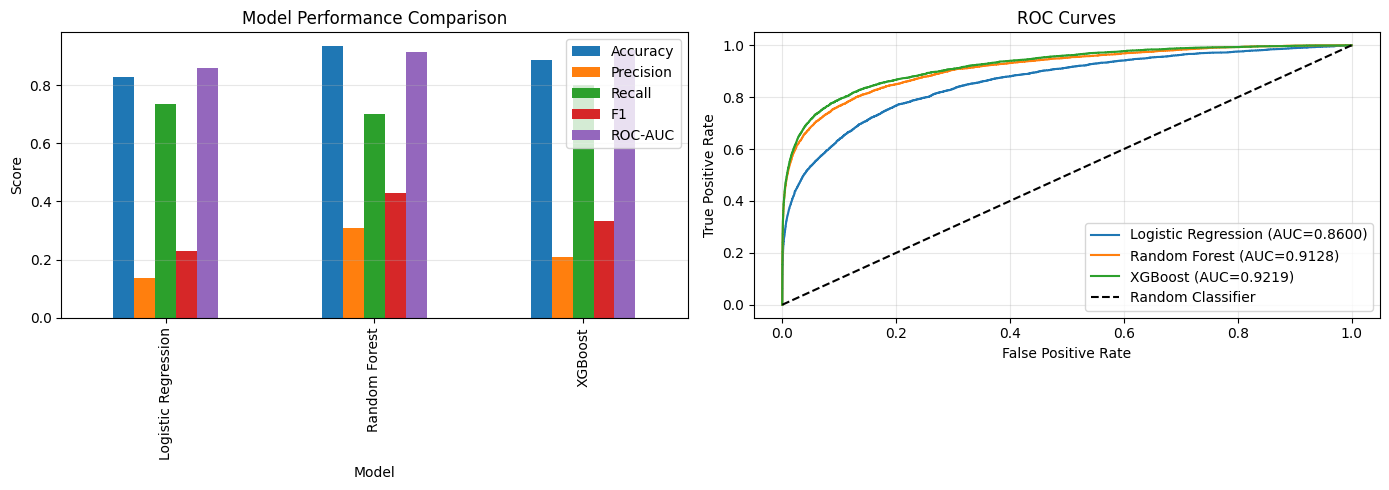

In [41]:
# ============================================================================
# 7. MODEL COMPARISON
# ============================================================================

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

results_df = pd.DataFrame({
    'Logistic Regression': results_lr,
    'Random Forest': results_rf,
    'XGBoost': results_xgb
})

print("\n" + results_df.to_string())

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of metrics
results_df.T.plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='best')
axes[0].grid(axis='y', alpha=0.3)

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb)

axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={results_lr["ROC-AUC"]:.4f})')
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={results_rf["ROC-AUC"]:.4f})')
axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={results_xgb["ROC-AUC"]:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
# ============================================================================
# 8. SELECT BEST MODEL AND MAKE PREDICTIONS
# ============================================================================

print("\n" + "="*70)
print("PREDICTION ON TEST DATA")
print("="*70)

# FIX: Create submissions folder if it doesn't exist
import os
submission_dir = 'data/submissions'
if not os.path.exists(submission_dir):
    os.makedirs(submission_dir)
    print(f"✓ Created folder: {submission_dir}")

# Select best model (based on ROC-AUC)
best_model_name = results_df.loc['ROC-AUC'].idxmax()
print(f"\nBest model: {best_model_name}")

if best_model_name == 'Logistic Regression':
    best_model = lr_model
    y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
else:
    best_model = xgb_model
    y_test_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Create submission file
submission_df = pd.DataFrame({
    'TransactionID': test_transaction_id,
    'isFraud': y_test_proba
})

# Save to CSV with proper path
submission_path = os.path.join(submission_dir, 'fraud_detection_submission.csv')
submission_df.to_csv(submission_path, index=False)
print(f"✓ Submission file saved to: {submission_path}")

print(f"\nSubmission preview:")
print(submission_df.head(10))

print(f"\nSubmission statistics:")
print(f"  - Total predictions: {len(submission_df)}")
print(f"  - Min probability: {submission_df['isFraud'].min():.4f}")
print(f"  - Max probability: {submission_df['isFraud'].max():.4f}")
print(f"  - Mean probability: {submission_df['isFraud'].mean():.4f}")
print(f"  - Median probability: {submission_df['isFraud'].median():.4f}")

# Verify file was created
if os.path.exists(submission_path):
    file_size = os.path.getsize(submission_path)
    print(f"✓ File created successfully! Size: {file_size} bytes")
else:
    print("✗ Error: File was not created!")


PREDICTION ON TEST DATA

Best model: XGBoost
✓ Submission file saved to: data/submissions\fraud_detection_submission.csv

Submission preview:
   TransactionID   isFraud
0        3663549  0.186602
1        3663550  0.157729
2        3663551  0.271621
3        3663552  0.086888
4        3663553  0.102204
5        3663554  0.107642
6        3663555  0.490768
7        3663556  0.476329
8        3663557  0.024360
9        3663558  0.217480

Submission statistics:
  - Total predictions: 506691
  - Min probability: 0.0007
  - Max probability: 0.9988
  - Mean probability: 0.2481
  - Median probability: 0.1796
✓ File created successfully! Size: 10086804 bytes


In [44]:
# ============================================================================
# 9. CONCLUSIONS AND INSIGHTS
# ============================================================================

print("\n" + "="*70)
print("CONCLUSIONS AND INSIGHTS")
print("="*70)

print(f"""
1. BEST PERFORMING MODEL: {best_model_name}
   - ROC-AUC Score: {results_df.loc['ROC-AUC', best_model_name]:.4f}
   - This model best distinguishes between fraudulent and non-fraudulent transactions.

2. KEY OBSERVATIONS:
   - The dataset shows significant class imbalance (fraud cases are rare).
   - Class weights were applied to handle this imbalance.
   - Models were evaluated using ROC-AUC, which is suitable for imbalanced datasets.

3. MODEL-SPECIFIC INSIGHTS:
   - Logistic Regression: Fast training, interpretable, good baseline.
   - Random Forest: Captures non-linear patterns, provides feature importance.
   - XGBoost: Often performs best for tabular data, handles imbalance well.

4. RECOMMENDATIONS:
   - Deploy the {best_model_name} model for production.
   - Monitor model performance regularly on new transactions.
   - Consider retraining periodically with new fraud patterns.
   - Use the predicted probabilities as a fraud risk score for transactions.
""")


CONCLUSIONS AND INSIGHTS

1. BEST PERFORMING MODEL: XGBoost
   - ROC-AUC Score: 0.9219
   - This model best distinguishes between fraudulent and non-fraudulent transactions.

2. KEY OBSERVATIONS:
   - The dataset shows significant class imbalance (fraud cases are rare).
   - Class weights were applied to handle this imbalance.
   - Models were evaluated using ROC-AUC, which is suitable for imbalanced datasets.

3. MODEL-SPECIFIC INSIGHTS:
   - Logistic Regression: Fast training, interpretable, good baseline.
   - Random Forest: Captures non-linear patterns, provides feature importance.
   - XGBoost: Often performs best for tabular data, handles imbalance well.

4. RECOMMENDATIONS:
   - Deploy the XGBoost model for production.
   - Monitor model performance regularly on new transactions.
   - Consider retraining periodically with new fraud patterns.
   - Use the predicted probabilities as a fraud risk score for transactions.

